## Training the model

The loop to train the model.

In [ ]:

import os

# Train the models
total_step = len(train_loader)
#for epoch in range(num_epochs):
#for epoch=0:
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 
        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
            if epoch % save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(model_path, 'rdecoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(model_path, 'rencoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import os
import pickle
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import statistics
model_path=F'/drive/My Drive/Colab Notebooks/Flickr8k' 
data_root='/drive/My Drive/Colab Notebooks' 
model_type ="RNN"
# model_type ="LSTM" 
smoothing = SmoothingFunction()

with open(vocab_path,'rb') as f:
    vocab=pickle.load(f)
 #iteration from epoch 3 to 5
if model_type == "RNN":
 
   encoder_path=os.path.join(model_path,'rencoder-{}-{}.ckpt'.format(5,230))
#    decoder_path=os.path.join(model_path,'rdecoder-{}-{}.ckpt'.format(5,230))
else:
#   encoder_path=os.path.join(model_path,'encoder-{}-{}.ckpt'.format(5, 140))
  decoder_path=os.path.join(model_path,'decoder-{}-{}.ckpt'.format(5, 140))

###iteration
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path)) 
encoder= encoder.to(device)
decoder= decoder.to(device)  
decoder.eval()
encoder.eval()
total_loss = []
Score =[]
Score_single=[]
sentence=[]
caption_sentence=[]

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        total_loss.append(loss)

        
        decoder.sample(features)
        sampled_ids=decoder.sample(features)
        
        sampled_id=sampled_ids[0].cpu().numpy()
    

        sampled_predict = []
        for word_id in sampled_id:
            word = vocab.idx2word[word_id]
            if word =='<start>': 
                continue 
            sampled_predict.append(word)
            if word == '<end>':
                break
        sampled_predict=sampled_predict[:-1]
        sentence.append(' '.join(sampled_predict))

        references=[]
        caption=captions.cpu().numpy()
        for cap in caption:
            reference=[]
            for word_id in cap:
                word = vocab.idx2word[word_id]
                if word =='<start>': 
                    continue 
                reference.append(word)
                if word == '<end>':
                    break
            reference=reference[:-1]
            caption_sentence.append(' '.join(reference))
            references.append(reference)
            Bleu_score_single=sentence_bleu(reference,sampled_predict,weights=(0.45,0.45,0.05,0.05),smoothing_function=smoothing.method2)
            Score_single.append(Bleu_score_single) 
        
        
        Bleu_score_total=sentence_bleu(references,sampled_predict,weights=(0.45,0.45,0.05,0.05),smoothing_function=smoothing.method2)       
        Score.append(Bleu_score_total)


    avg_loss = torch.mean(torch.Tensor(total_loss))
    max_Score=max(Score)
    avg_Score=statistics.mean(Score)

    print(avg_loss)
    print(max_Score)
    print(avg_Score)

with open(data_root+"/score_rnn.txt", "wb") as fp:   
    pickle.dump(Score, fp)
with open(data_root+"/total_loss_rnn.txt", "wb") as fp:   
    pickle.dump(total_loss, fp)
with open(data_root+"/Score_single_rnn.txt", "wb") as fp:   
    pickle.dump(Score_single, fp)

np.save(data_root+"/caption_sentence_rnn",np.array(caption_sentence))
np.save(data_root+"/sentence_rnn",np.array(sentence))

# with open(data_root+"/score_lstm.txt", "wb") as fp:   
#     pickle.dump(Score, fp)
# with open(data_root+"/total_loss_lstm.txt", "wb") as fp:   
#     pickle.dump(total_loss, fp)
# with open(data_root+"/Score_single_lstm.txt", "wb") as fp:   
#     pickle.dump(Score_single, fp)

# np.save(data_root+"/caption_sentence_LSTM",np.array(caption_sentence))
# np.save(data_root+"/sentence_LSTM",np.array(sentence))








tensor(2.7056)
1.0
0.35835554850664847


In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import os
import pickle
data_root='/drive/My Drive/Colab Notebooks' 

with open(data_root+"/score_lstm.txt", "rb") as fp:   # Unpickling
     score_lstm = pickle.load(fp)
# with open(data_root+"/total_loss_lstm.txt", "rb") as fp:   # Unpickling
#      total_loss_lstm = pickle.load(fp)
with open(data_root+"/Score_single_lstm.txt", "rb") as fp:   # Unpickling
     Score_single_lstm = pickle.load(fp)

caption_sentence_lstm=np.load(data_root+"/caption_sentence_LSTM.npy")
sentence_lstm=np.load(data_root+"/sentence_LSTM.npy")

with open(data_root+"/score_rnn.txt", "rb") as fp:   # Unpickling
     score_rnn = pickle.load(fp)
# with open(data_root+"/total_loss_rnn.txt", "rb") as fp:   # Unpickling
#      total_loss_rnn = pickle.load(fp)
with open(data_root+"/Score_single_rnn.txt", "rb") as fp:   # Unpickling
     Score_single_rnn = pickle.load(fp)

caption_sentence_rnn=np.load(data_root+"/caption_sentence_rnn.npy")
sentence_rnn=np.load(data_root+"/sentence_rnn.npy")

# loss_lstm=[]
# loss_rnn=[]
# for i in range(len(total_loss_lstm)):
#     loss_lstm.append(total_loss_lstm[i].cpu().numpy())
# for i in range(len(total_loss_rnn)):
#     loss_rnn.append(total_loss_rnn[i].cpu().numpy())

# diff_loss= np.array(loss_lstm)-np.array(loss_rnn)
# max_diff=max(diff_loss)
# min_diff=max(diff_loss)

# print(max_diff,min_diff)


In [ ]:
diff_score= np.array(score_lstm)-np.array(score_rnn)
max_diff=max(diff_score)
min_diff=min(diff_score)
print(max_diff,min_diff)

0.7143239563978692 -0.43121331812725827


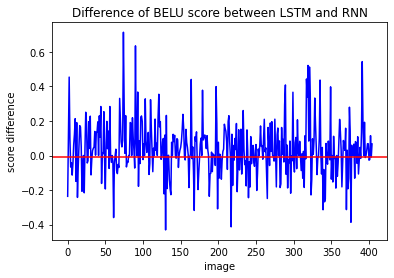

In [ ]:
import matplotlib.pyplot as plt                                                                                                      
import numpy as np                                                                                                                   
x=np.arange(0,405,1)                                                                                                                                                                     
plt.plot(x,diff_score, color = 'blue', label = 'diff_score')
plt.axhline(y=0,color='r',linestyle='-')                                                          
plt.xlabel("image")
plt.ylabel('score difference')  
plt.title("Difference of BELU score between LSTM and RNN")                                                                                                                                                                                       
plt.show() 


In [ ]:
L=len(sentence_lstm)
D=np.arange(0,L, round(L/10))
D[-1]=405

import statistics

def generate_short_long_sentence(sentence,score):
    length=[]
    stat=[]
    for i, sen in enumerate (sentence):
        length.append(len(sen.split()))
    leng=sorted(length)
    ave_leng=statistics.mean(leng)
    sort_index=(np.array(length)).argsort()
    for i in range(1,11):
        prop_index=sort_index[D[i-1]:D[i]]
        prop_length=statistics.mean(leng[D[i-1]:D[i]])
        prop_score=statistics.mean(np.array(score)[prop_index])
        stat.extend([prop_length,prop_score])
    return stat,ave_leng



In [ ]:
stat_lstm=generate_short_long_sentence(sentence_lstm,score_lstm)
stat_rnn=generate_short_long_sentence(sentence_rnn,score_rnn)
stat_lstm


[10.355555555555556, 8, 12.15, 0.4777028616115563, 0.3689738648493813]

In [ ]:
def generate_short_long_caption(sentence,caption_sentence,score):
    cap1_score=[]
    cap2_score=[]
    cap3_score=[]
    cap4_score=[]
    cap5_score=[]
    for i, sen in enumerate (sentence):
        length=[]
        single_score=score[i*5:i*5+5]
        for cap in caption_sentence[i*5:i*5+5]:
            length.append(len(cap.split()))
        leng=sorted(length)
        sort_index=(np.array(length)).argsort()
        caption1=sort_index[0]
        caption2=sort_index[1]
        caption3=sort_index[2]
        caption4=sort_index[3]
        caption5=sort_index[4]
        cap1_score.append(np.array(single_score)[caption1])
        cap2_score.append(np.array(single_score)[caption2])
        cap3_score.append(np.array(single_score)[caption3])
        cap4_score.append(np.array(single_score)[caption4])
        cap5_score.append(np.array(single_score)[caption5])
    return cap1_score,cap2_score,cap3_score,cap4_score,cap5_score

In [ ]:
single_lstm=generate_short_long_caption(sentence_lstm,caption_sentence_lstm,Score_single_lstm)
single_rnn=generate_short_long_caption(sentence_rnn,caption_sentence_rnn,Score_single_rnn)
diff1=np.array(single_lstm[0])-np.array(single_rnn[0])
diff2=np.array(single_lstm[1])-np.array(single_rnn[1])
diff3=np.array(single_lstm[2])-np.array(single_rnn[2])
diff4=np.array(single_lstm[3])-np.array(single_rnn[3])
diff5=np.array(single_lstm[4])-np.array(single_rnn[4])

In [ ]:
import statistics
statistics.mean(diff5)


-0.005393087102448577

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import os
import pickle
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import statistics
model_path=F'/drive/My Drive/Colab Notebooks/Flickr8k' 
data_root='/drive/My Drive/Colab Notebooks' 
model_type ="RNN"
#model_type ="LSTM" 
smoothing = SmoothingFunction()

with open(vocab_path,'rb') as f:
    vocab=pickle.load(f)
 #iteration from epoch 3 to 5
for iteration in range (0,310,10): 
    
    # encoder_path=os.path.join(model_path,'rencoder-{}-{}.ckpt'.format(5,iteration))
    # decoder_path=os.path.join(model_path,'rdecoder-{}-{}.ckpt'.format(5,iteration))
    
    encoder_path=os.path.join(model_path,'encoder-{}-{}.ckpt'.format(5, iteration))
    decoder_path=os.path.join(model_path,'decoder-{}-{}.ckpt'.format(5, iteration))


###iteration
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path)) 
    encoder= encoder.to(device)
    decoder= decoder.to(device)  
    decoder.eval()
    encoder.eval()
    total_loss = []
    Score =[]
    Score_single=[]
    sentence=[]
    caption_sentence=[]

    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(test_loader):

            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)

            # Packed as well as we'll compare to the decoder outputs
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss.append(loss)

            
            decoder.sample(features)
            sampled_ids=decoder.sample(features)
            
            sampled_id=sampled_ids[0].cpu().numpy()
        

            sampled_predict = []
            for word_id in sampled_id:
                word = vocab.idx2word[word_id]
                if word =='<start>': 
                    continue 
                sampled_predict.append(word)
                if word == '<end>':
                    break
            sampled_predict=sampled_predict[:-1]
            sentence.append(' '.join(sampled_predict))

            references=[]
            caption=captions.cpu().numpy()
            for cap in caption:
                reference=[]
                for word_id in cap:
                    word = vocab.idx2word[word_id]
                    if word =='<start>': 
                        continue 
                    reference.append(word)
                    if word == '<end>':
                        break
                reference=reference[:-1]
                caption_sentence.append(' '.join(reference))
                references.append(reference)
                Bleu_score_single=sentence_bleu(reference,sampled_predict,weights=(0.45,0.45,0.05,0.05),smoothing_function=smoothing.method2)
                Score_single.append(Bleu_score_single) 
            
            
            Bleu_score_total=sentence_bleu(references,sampled_predict,weights=(0.45,0.45,0.05,0.05),smoothing_function=smoothing.method2)       
            Score.append(Bleu_score_total)


    avg_loss = torch.mean(torch.Tensor(total_loss))
    max_Score=max(Score)
    avg_Score=statistics.mean(Score)

    print('%d %f' %(iteration,avg_loss))
    print('%d %f' %(iteration,max_Score))
    print('%d %f' %(iteration,avg_Score))




0 2.612901
0 1.000000
0 0.384700
10 2.620294
10 1.000000
10 0.394613
20 2.613599
20 1.000000
20 0.393151
30 2.620571
30 1.000000
30 0.390063
40 2.626421
40 1.000000
40 0.382793
50 2.632714
50 0.965936
50 0.353220
60 2.621273
60 1.000000
60 0.370099
70 2.616544
70 0.993346
70 0.362338
80 2.629526
80 1.000000
80 0.358706
90 2.621149
90 1.000000
90 0.368911
100 2.618364
100 1.000000
100 0.388078
110 2.608136
110 0.990925
110 0.376880
120 2.606964
120 0.990925
120 0.374050
130 2.601155
130 0.993346
130 0.393674
140 2.604571
140 1.000000
140 0.395532
150 2.610748
150 0.983317
150 0.387855
160 2.596240
160 0.983317
160 0.386849
170 2.590369
170 1.000000
170 0.387422
180 2.591823
180 1.000000
180 0.388577
190 2.597729
190 0.990925
190 0.384560
200 2.595628
200 1.000000
200 0.395461
210 2.605636
210 0.972407
210 0.381463
220 2.598003
220 0.985719
220 0.374383
230 2.591707
230 0.977654
230 0.380509
240 2.598599
240 0.947388
240 0.367879
250 2.584662
250 0.993346
250 0.394858
260 2.581159
260 1.

In [ ]:

import torch
import torch.utils.data as data
import numpy as np
import os
import pickle
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import statistics

model_path=F'/drive/My Drive/Colab Notebooks/Flickr8k' 
data_root='/drive/My Drive/Colab Notebooks' 
score_lstm=torch.load(data_root+'/Score_LSTM' )




    
    
    
    

FileNotFoundError: ignored

In [ ]:
torch.save(torch.Tensor(total_loss), data_root+'/total_loss_LSTM' )
torch.save(torch.Tensor(Score_single), data_root+'/Score_single_LSTM')   
np.save(data_root+"/caption_sentence_LSTM",np.array(caption_sentence))
np.save(data_root+"/sentence_LSTM",np.array(sentence))